## Import

In [1]:
# importing the libraries
import os
import pandas as pd
import numpy as np
from itertools import chain

# for reading and displaying images
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# models
from src.architectures.model_util import load_model, save_checkpoint

# other files
from src.run import *
from src.data_util import *

# Torch
from torch.optim import *
import torch.optim as optim
from torchsummary import summary
from tensorboardX import SummaryWriter

# Maintenance
import mlflow
from DeepNotion.build import *

# CAM - M3dCam
from medcam import medcam

## Load Configurations

In [2]:
from src.config import *
cfg = load_config()

## MLFlow Init

In [3]:
exp_name = '3dcnn_smri'
try:
    mlflow.create_experiment(name=exp_name)
except:
    print('Existing experiment')
    
mlflow.set_experiment(exp_name)

Existing experiment


Pararmeters to write

In [4]:
params = dict()
for name, value in cfg.get_dict().items():
    if name not in ['notion']:
        params[name] = str(value)

## Tracking on Notion

In [5]:
if cfg['notion']['use']:

    print(today())
    root, client = login('./config.yml')
    page = make_page(root)

    toggle = page.children.add_new(ToggleBlock, title='Configuration')

    for name, value in cfg.get_dict().items():
        if name not in ['notion']:
            txt = '**' + name + '** ' + str(value)
            toggle.children.add_new(BulletedListBlock, title=txt)

    fold_db = make_db(page, schema=cfg.schema)
    test_db = make_db(page, schema=cfg.test_schema)

## Train

### No Fold

In [6]:
model, cfg.device = load_model(cfg.model_name, verbose=False)
optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)

trn_dp, aug_dp, tst_dp = DataPacket(), DataPacket(), DataPacket()
aug_dp.delete('corr')

mlflow.start_run()
mlflow.log_params(params)

Model Resnet is selected.


In [7]:
best_mae = cfg.best_mae
fold = None
db = make_db(page, schema=cfg.schema, title='Results') if cfg['notion']['use'] else None
for e in range(cfg.epochs):
    
    start_time = time.time()
    print(f'Epoch {e+1} / {cfg.epochs}, BEST MAE {best_mae:.3f}')
    
    cfg.test = False
    model, trn_dp, trn_res = train(model, optimizer, fn_lst, trn_dp, cfg, fold=fold)
    model, aug_dp, aug_res = train(model, optimizer, fn_lst, aug_dp, cfg, fold=fold, augment=True)
    cfg.test = True
    model, tst_dp, tst_res = eval(model, fn_lst, tst_dp, cfg, fold=fold)
    elapsed_time = round(time.time() - start_time, 3)
       
    if best_mae > tst_dp.mae[-1]:
        
        best_mae = tst_dp.mae[-1]
        model_name = f'{cfg.model_name}_ep{e}-{cfg.epochs}_sd{cfg.seed}_mae{best_mae:.3f}.pt'
        save_checkpoint(cfg.get_dict(), model_name, is_best=True)
        
    df = pd.concat([make_df(trn_res, 'Train'),
                    make_df(aug_res, 'Aug'),
                    make_df(tst_res, 'Test')], ignore_index=True)
    
    trn_dp.corr.update(df[df['Label'] == 'Train'].corr().Prediction['True'])
    trn_dp.refresh()
    tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
    tst_dp.refresh()

    if e % 1 == 0:
        trn_dp.info('train')
        aug_dp.info('augme')
        tst_dp.info('test ')

    if (e+1) % 5 == 0:
        plt.title(f"L1 Losses among epochs, {e}th")
        plt.plot(list(trn_dp.loss), label='Train')
        plt.plot(list(tst_dp.loss), label='Test')
        plt.grid(); plt.legend()

        sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
        plt.grid()
        plt.show()
        
        if db:
            data = gather_data(e=e, time=elapsed_time, cfg=cfg,
                               train=trn_dp, valid=tst_dp, aug=aug_dp)
            write_db(db, data)
    
    metrics = mlflow_data(time=elapsed_time, train=trn_dp, valid=tst_dp, aug=aug_dp)
    mlflow.log_metrics(metrics, e)
    
    torch.cuda.empty_cache()
    
mlflow.end_run()

Epoch 1 / 100, BEST MAE 10.000
[train] 51.1 sec [train] 151.6 sec [eval] 12.2 sec 
[TRAIN]:: Loss=3411.567 Mae=56.066 Rmse=58.350 Corr=0.447 
[AUGME]:: Loss=3313.219 Mae=55.374 Rmse=57.499 
[TEST ]:: Loss=3230.259 Mae=54.770 Rmse=56.735 Corr=0.666 
Epoch 2 / 100, BEST MAE 10.000
[train] 50.5 sec [train] 162.1 sec [eval] 12.2 sec 
[TRAIN]:: Loss=3247.994 Mae=54.849 Rmse=56.928 Corr=0.717 
[AUGME]:: Loss=3198.117 Mae=54.423 Rmse=56.488 
[TEST ]:: Loss=3068.977 Mae=53.269 Rmse=55.296 Corr=0.640 
Epoch 3 / 100, BEST MAE 10.000
[train] 50.7 sec [train] 140.2 sec 

KeyboardInterrupt: 

### kFold

In [6]:
models = []
packets = []
tst_dp = DataPacket()

#### Whole Run

In [ ]:
test_db = make_db(page, schema=cfg.test_schema, title='Test') if cfg['notion']['use'] else None
for fold in range(cfg.folds):
    
    print(f'Fold {fold+1} / {cfg.folds}')
    mlflow.start_run(run_name=f'{today()} Fold {fold+1}')
    mlflow.log_params(params)
    mlflow.set_tags({
        'fold': fold+1
    })

    fold_db = make_db(page, schema=cfg.schema, title=f'Fold {fold+1}') if cfg['notion']['use'] else None
    model, dps, res = run(cfg, fold, fold_db, mlflow=mlflow)
    models.append(model)
    packets.append(dps)
    
    cfg.test = True
    model, tst_dp, tst_res = eval(model, fn_lst, tst_dp, cfg, fold=None)
    
    df = pd.concat([make_df(res[0], 'Train'),
                   make_df(res[1], 'Valid'),
                   make_df(tst_res, 'Test')], ignore_index=True)
    
    tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
    tst_dp.refresh()
    
    # Show Holdout testset information
    tst_dp.info('Holdout test')
    sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
    plt.grid()
    plt.show()
    
    if test_db:
        data = gather_data(e=e, train=trn_dp, test=tst_dp)
        write_db(test_db, data)
    
    torch.cuda.empty_cache()

Fold 1 / 5
Model Resnet is selected.


## Ensemble

### Naive Averaging

In [39]:
# Ensemble
preds = dict()
models = glob('./models/ensembles/*.pth')
for fold, state in enumerate(models):
    
    model, device = load_model('resnet', verbose=False)
    model = torch.load(state)
    
    model, (_, _, _), tst_preds = eval(model, True, None, None, resize, device, batch_size,
                                      loss_fn, mae_fn, rmse_fn,
                                      [], [], [])
    
    preds[f'model_{fold}'] = list(map(float, tst_preds[1]))
    
ensemble_results = pd.DataFrame(preds)
ensemble_results['Avg'] = ensemble_results.mean(axis=1)
ensemble_results['True'] = list(map(float, tst_preds[0]))

Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.


In [64]:
def result_plot(df):
    
    avg = torch.Tensor(ensemble_results['Avg'])
    tru = torch.Tensor(ensemble_results['True'])
    
    corr = ensemble_results.corr()['True']['Avg']
    mae_fn, rmse_fn = nn.L1Loss(), RMSELoss()
    
    print(f'Ensemble Results')
    print(f'MAE  = {float(mae_fn(avg, tru)):.3f}')
    print(f'RMSE = {float(rmse_fn(avg, tru)):.3f}')
    print(f'CORR = {corr:.3f}')
    
    sns.lmplot(data=ensemble_results, x='True', y='Avg')
    plt.grid()
    plt.show()

Ensemble Results
MAE  = 7.025
RMSE = 8.598
CORR = 0.854


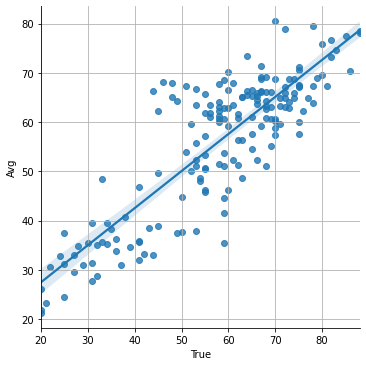

In [65]:
result_plot(ensemble_results)

### Blender

In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [8]:
class CFG:
    
    model_name='resnet'
    dropout=0.1
    use_last_layer=True

In [10]:
class Ensemble(nn.Module):
    
    def __init__(self, model_list, CFG):
        super(Ensemble, self).__init__()
        
        self.cfg = CFG
        self.dropout = self.cfg.dropout
        self.models = dict()
        
        for idx, model_path in enumerate(model_list):
            
            model, device = load_model(self.cfg.model_name, verbose=False)
            model = torch.load(model_path)
            if not self.cfg.use_last_layer:
                model.fc = Identity()
                
                self.last_layer = nn.Sequential(
                    nn.Linear(len(model_list) * 128, 128),
                    nn.Dropout(self.dropout),
                    nn.Linear(128, 1)
#                     nn.Dropout(self.dropout)
                )
                
            else:
                self.last_layer = nn.Sequential(
                    nn.Linear(len(model_list), 1),
#                     nn.Dropout(self.dropout)
                )
                
            for param in model.parameters():
                param.requires_grad = False
                
            self.models[idx] = model
        
    def forward(self, x):
        
        vectors = list()
        for idx, model in self.models.items():
            vectors.append(model(x))
            
        x = torch.cat(vectors, dim=1)
        x = self.last_layer(x)
        
        return x

In [11]:
model_list = glob('./models/ensembles/rough/*.pth')
model_list.sort()
cfg = CFG()
cfg.use_last_layer = True
model = Ensemble(model_list, cfg).to(device)
with torch.no_grad():
    model.last_layer[0].weight.fill_(1 / len(model_list))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
